# Exploring Odds as Implied Probabilities

In [3]:
import pathlib
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt # creating visualizations
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
import numpy as np # basic math and random numbers

import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning

from scipy import optimize
from sklearn.metrics import mean_squared_error

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# add the 'src' directory to path to import modules
src_dir = pathlib.Path().cwd().resolve().parent / 'src'
#src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
# import my class code from the source
# %aimport src-dir.filename

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


DATA_PATH = pathlib.Path().cwd().resolve().parent / 'data' / 'soccer' / 'raw' / 'United Kingdom' / 'english premier league' / '2000-2001' / 'football-data-co-uk' / 'season-data' / '2000-2001.csv' 
print(DATA_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/soccer/raw/United Kingdom/english premier league/2000-2001/football-data-co-uk/season-data/2000-2001.csv


In [4]:
df = pd.read_csv(DATA_PATH)
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HO,AO,HY,AY,HR,AR,HBP,ABP,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA
0,E0,19/08/00,Charlton,Man City,4,0,H,2,0,H,20043,Rob Harris,17,8,14,4,2,1,6,6,13,12,8,6,1,2,0,0,10,20,2.00,3.0,3.2,2.20,2.9,2.7,2.20,3.25,2.75,2.20,3.25,2.88,2.10,3.2,3.10
1,E0,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,34914,Graham Barber,17,12,10,5,1,0,7,7,19,14,2,3,1,2,0,0,10,20,1.47,3.4,5.2,1.60,3.2,4.2,1.50,3.40,6.00,1.50,3.60,6.00,1.44,3.6,6.50
2,E0,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,20624,Barry Knight,6,16,3,9,0,1,8,4,15,21,1,3,5,3,1,0,75,30,2.15,3.0,3.0,2.20,2.9,2.7,2.25,3.20,2.75,2.30,3.20,2.75,2.30,3.2,2.62
3,E0,19/08/00,Derby,Southampton,2,2,D,1,2,A,27223,Andy D'Urso,6,13,4,6,0,0,5,8,11,13,0,2,1,1,0,0,10,10,2.00,3.1,3.2,1.80,3.0,3.5,2.20,3.25,2.75,2.05,3.20,3.20,2.00,3.2,3.20
4,E0,19/08/00,Leeds,Everton,2,0,H,2,0,H,40010,Dermot Gallagher,17,12,8,6,0,0,6,4,21,20,6,1,1,3,0,0,10,30,1.65,3.3,4.3,1.55,3.3,4.5,1.55,3.50,5.00,1.57,3.60,5.00,1.61,3.5,4.50


In [5]:
df.describe()

,FTHG,FTAG,HTHG,HTAG,Attendance,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HO,AO,HY,AY,HR,AR,HBP,ABP,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,325.000000,325.000000,325.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,1.544737,1.065789,0.686842,0.476316,32911.721053,12.792105,9.378947,6.163158,4.531579,0.381579,0.223684,6.289474,4.647368,12.978947,13.944737,3.628947,3.728947,1.347368,1.794737,0.084211,0.081579,15.578947,19.986842,2.162237,3.382632,3.963553,2.057895,3.132368,3.469605,2.190277,3.415569,3.967354,2.184500,3.407711,4.077526,2.182237,3.403079,4.009053
std,1.285436,1.029070,0.843623,0.694469,12600.528803,4.859117,3.609366,2.991582,2.239382,0.640891,0.459399,3.001388,2.742583,4.164757,4.382695,2.602354,2.615703,1.260468,1.309585,0.287402,0.292704,15.126784,15.578123,0.853259,0.423285,1.964800,0.610196,0.337662,1.417318,0.888833,0.347241,2.086878,0.894861,0.369623,2.086965,0.919950,0.378054,2.139420
min,0.000000,0.000000,0.000000,0.000000,14651.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000,2.900000,1.350000,1.200000,2.700000,1.450000,1.170000,2.870000,1.360000,1.180000,3.000000,1.400000,1.160000,2.900000,1.330000
25%,1.000000,0.000000,0.000000,0.000000,22006.000000,9.000000,7.000000,4.000000,3.000000,0.000000,0.000000,4.000000,3.000000,10.000000,11.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,10.000000,1.600000,3.150000,2.600000,1.600000,2.900000,2.500000,1.570000,3.200000,2.400000,1.570000,3.200000,2.500000,1.570000,3.200000,2.500000
50%,1.000000,1.000000,0.000000,0.000000,33199.000000,12.000000,9.000000,6.000000,4.000000,0.000000,0.000000,6.000000,4.000000,13.000000,13.000000,3.000000,3.000000,1.000000,2.000000,0.000000,0.000000,10.000000,20.000000,1.950000,3.250000,3.400000,1.900000,3.000000,3.100000,1.910000,3.250000,3.250000,2.000000,3.250000,3.300000,1.900000,3.300000,3.400000
75%,2.000000,2.000000,1.000000,1.000000,38343.500000,16.000000,12.000000,8.000000,6.000000,1.000000,0.000000,8.000000,6.000000,16.000000,17.000000,5.000000,5.000000,2.000000,3.000000,0.000000,0.000000,20.000000,30.000000,2.450000,3.450000,4.762500,2.300000,3.200000,4.200000,2.500000,3.500000,5.000000,2.500000,3.400000,5.312500,2.500000,3.500000,5.000000
max,6.000000,4.000000,5.000000,4.000000,67637.000000,33.000000,24.000000,19.000000,14.000000,4.000000,2.000000,17.000000,14.000000,25.000000,28.000000,14.000000,17.000000,7.000000,7.000000,2.000000,2.000000,85.000000,90.000000,7.200000,5.500000,11.000000,5.000000,4.700000,9.000000,7.000000,5.500000,12.000000,7.000000,5.500000,11.000000,8.000000,5.500000,12.000000


## Normalize Odds to Implied Probabilities

Take the William Hill Odds - `WH` - and normalize them to three probabilities summing to 1

In [6]:
# tot includes the bookie's overround
tot = 1/df['WHH'] + 1/df['WHD'] + 1/df['WHA']
hwin = 1/df['WHH']/tot; draw = 1/df['WHD']/tot; awin = 1/df['WHA']/tot
print(tot[0:5])
print(hwin[0:5])

0    1.111271
1    1.126068
2    1.128962
3    1.125000
4    1.129055
dtype: float64
0    0.428510
1    0.616698
2    0.385117
3    0.444444
4    0.550122
dtype: float64


### Review Distributions

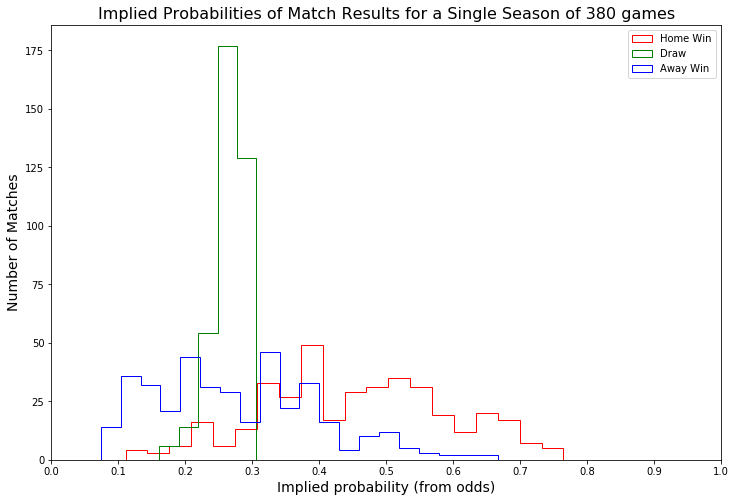

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
bins=20
ax.hist(hwin, histtype='step', bins=bins, color='red', density=False, label='Home Win')
ax.hist(draw, histtype='step', bins=5, color='green', density=False, label='Draw', alpha=1.0)
ax.hist(awin, histtype='step', bins=bins, color='blue', density=False, label='Away Win')
ax.set_xlim(0,1.0, 0.1)
ax.set_xticks(np.linspace(0, 1.0, 11))
ax.set_xlabel('Implied probability (from odds)', fontsize=14)
ax.set_ylabel('Number of Matches', fontsize=14)
ax.set_title('Implied Probabilities of Match Results for a Single Season of 380 games', fontsize=16)


plt.legend()
plt.show();

Bin size adjusted on Draw Probabilities to make each bin approximately cover the same probability range on the x axis for all 3 types of result

Some Notes:
+ How could these distributions be modeled?
+ Why is the Draw probability distribution so narrow compared to the other two
+ The Home Win (red) distribution is centred further to the right than the other distributions. This is the home field advantage
+ If Home Field Advantage reduces, does the location of both the away win, and draw distributions get higher, or does the draw location stay the same, and the away win location get bigger. Or, do they share the gain equally, or in proportion to their previous locations?

### Plot each game from lowest home win probability to highest as a sandbar chart
### Try other sorts and plot

### Scatter Plots

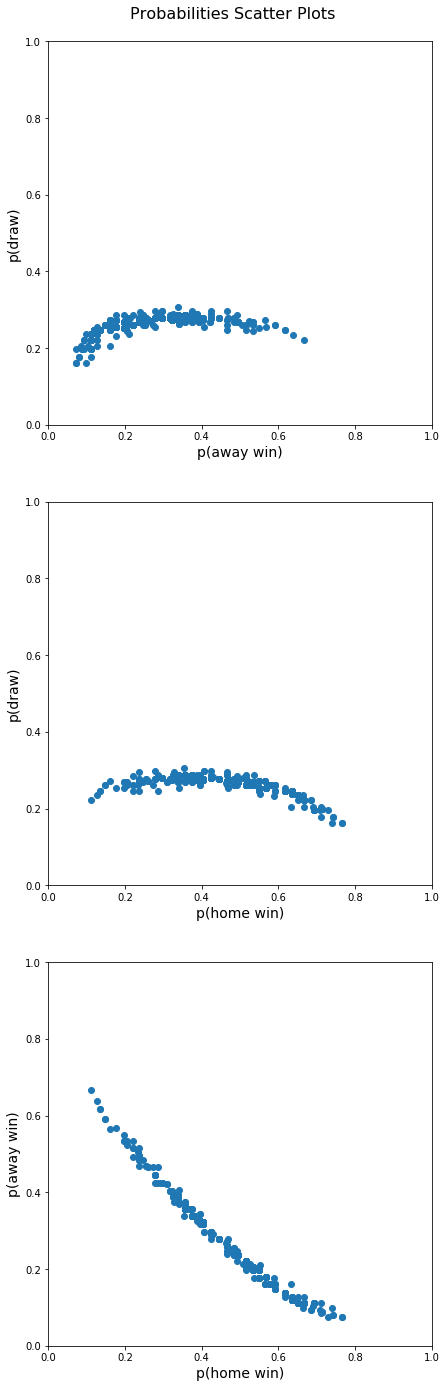

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,24))
ax1, ax2, ax3 = axs
lims = (0,1)
ax1.scatter(awin, draw)
ax1.set_xlabel('p(away win)', fontsize=14)
ax1.set_ylabel('p(draw)', fontsize=14)
ax1.set_aspect('equal')
ax1.set_xlim(lims)
ax1.set_ylim(lims)

ax2.scatter(hwin, draw)
ax2.set_xlabel('p(home win)', fontsize=14)
ax2.set_ylabel('p(draw)', fontsize=14)
ax2.set_aspect('equal')
ax2.set_xlim(lims)
ax2.set_ylim(lims)

ax3.scatter(hwin, awin)
ax3.set_xlabel('p(home win)', fontsize=14)
ax3.set_ylabel('p(away win)', fontsize=14)
ax3.set_aspect('equal')
ax3.set_xlim(lims)
ax3.set_ylim(lims)

plt.suptitle('Probabilities Scatter Plots', fontsize=16, y=0.9)
plt.show();

### The implied Probabilities lie on a Plane

The equation for a plane is:
 $$ax + by +c = z$$
 
 and we know that our probabilities must add up to 1
 
 If we have a guaranteed home win the point is: 1home + 0away + 0draw = 1
 
 If we have a guaranteed away win the point is: 0home + 1away + 0draw = 1
  
 If we have a guaranteed draw the point is: 0home + 0away + 1draw = 1
 
 Our implied probabilities must sit somewhere on this plane

<IPython.core.display.Javascript object>


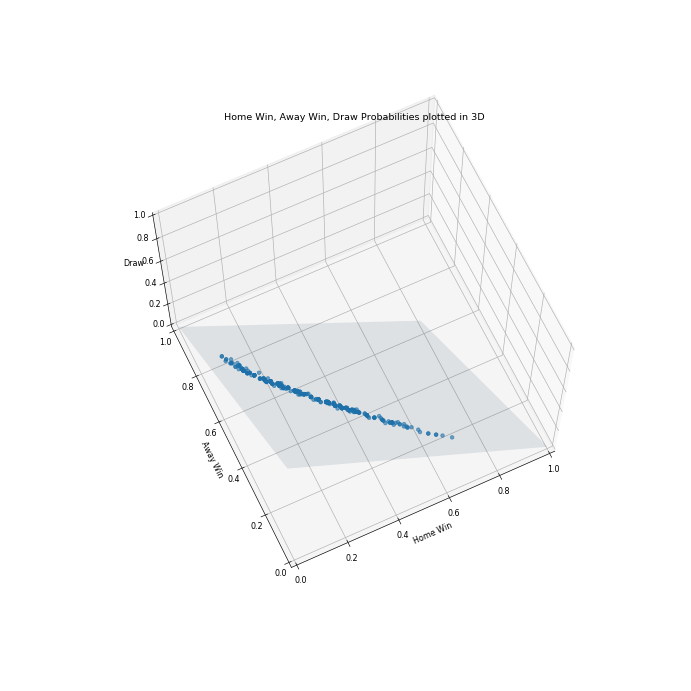

In [10]:
# Leave both these in. If no plot run cell again
%matplotlib notebook
%matplotlib notebook
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Create the plane that the points sit on x + y + z  1
points = np.array([[1,0,0], [0,1,0], [0,0,1]])
p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

point  = np.array(p0)
normal = np.array(u_cross_v)

d = -point.dot(normal)

xx, yy = np.meshgrid(range(2), range(2))

z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]


# Plot the plane that the points sit on  - x + y + z = 1
ax.plot_surface(xx, yy, z, alpha=0.1)
ax.scatter(awin, hwin, draw, alpha=0.6)
ax.set_title('Home Win, Away Win, Draw Probabilities plotted in 3D')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_zlim(lims)
ax.set_xlabel('Home Win')
ax.set_ylabel('Away Win')
ax.set_zlabel('Draw')
plt.show();

## Home, Away, Draw Implied Probabilities on a Scatter Plot

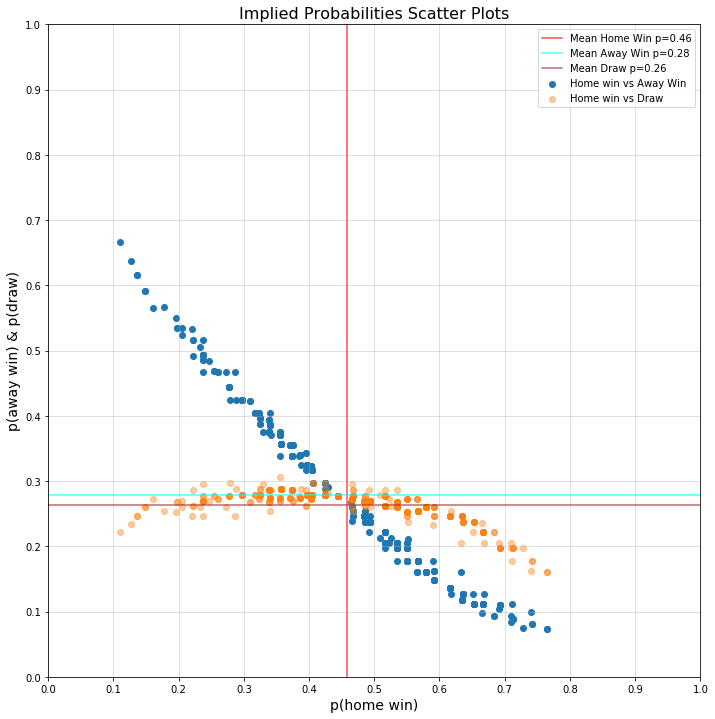

In [11]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,12))
lims = (0,1)

ax.scatter(hwin, awin, label = 'Home win vs Away Win')
ax.scatter(hwin, draw, alpha=0.4, label = 'Home win vs Draw')
ax.axvline(np.mean(hwin), color='red', label = f'Mean Home Win p={round(np.mean(hwin),2)}', alpha=0.7)
ax.axhline(np.mean(awin), color='cyan', label = f'Mean Away Win p={round(np.mean(awin),2)}', alpha=0.7)
ax.axhline(np.mean(draw), color='brown', label = f'Mean Draw p={round(np.mean(draw),2)}', alpha=0.7)
ax.set_xlabel('p(home win)', fontsize=14)
ax.set_ylabel('p(away win) & p(draw)', fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xticks(np.linspace(0,1.0,11))
ax.set_yticks(np.linspace(0,1.0,11))

ax.set_title('Implied Probabilities Scatter Plots', fontsize=16)
plt.grid(alpha=0.5)
plt.legend()
plt.show();

This plot is very interesting

Some notes:

+ The y value of the orange dot + the y value of the blue dot = 1
+ The range of home win probabilities is from about 0.1 to 0.8, whereas the range of away win probabilities is from about 0.08 to 0.7
+ The mean of the win probabilities (red vertical line) is 0.46, whereas it is 0.28 (cyan horizontal line) for the away win probabilities. This illustrates the home field advantage.
+ Out of the 3 probabilities, the mean probability is lowest for a draw at 0.26
+ The range of draw probabilities is lowest ranging from about 0.15 to 0.3
+ At any given home win probability, the probability range for a draw is only about 0.05 

## Curve Fitting

In [12]:
# Define a model function needed as input to scipy
def model_func(x, a0, a1, a2, a3):
    return a0 + (a1*x) + (a2*x**2) + (a3*x**3)

# call curve_fit, passing in the model function and data; then unpack the results
param_opt, param_cov = optimize.curve_fit(model_func, hwin.values, awin.values)
print(*param_opt)

0.7777672258427051 -1.2169736120008672 -0.038621484273597906 0.5485886141978232


In [13]:
y_pred = model_func(hwin, *param_opt)
rss = np.sum(np.square(y_pred - awin))
print(rss)

0.027052856181589917


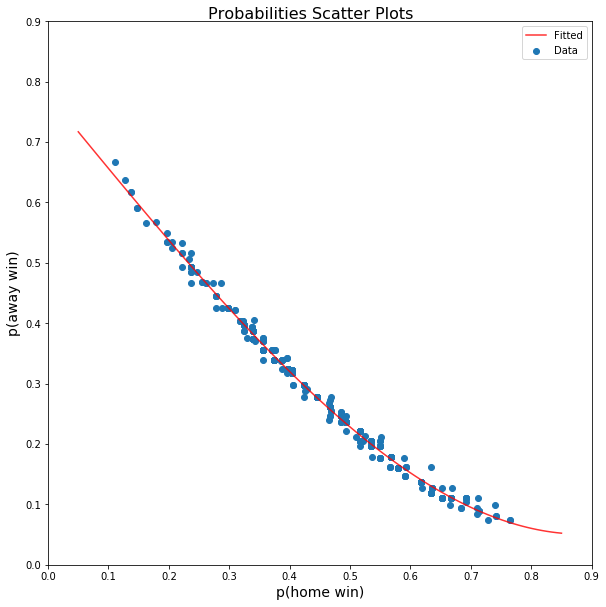

In [14]:
xmin = np.min(hwin)
xmax = np.max(hwin)
xrange = np.linspace(np.min(hwin)-0.1, np.max(hwin)+0.1, 100)
xrange = np.linspace(0.05, 0.85, 100)

ymodel = model_func(xrange, *param_opt)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(hwin, awin, label = 'Data')
ax.plot(xrange, ymodel, color='red', alpha=0.8, label = 'Fitted')
ax.set_xlabel('p(home win)', fontsize=14)
ax.set_ylabel('p(away win)', fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0, 0.9)
ax.set_ylim(0, 0.9)

plt.suptitle('Probabilities Scatter Plots', fontsize=16, y=0.9)
plt.legend()
plt.show();

Grab all the points below the curve, and get the odds

Same for points above the curve

In [15]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HO,AO,HY,AY,HR,AR,HBP,ABP,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA
0,E0,19/08/00,Charlton,Man City,4,0,H,2,0,H,20043,Rob Harris,17,8,14,4,2,1,6,6,13,12,8,6,1,2,0,0,10,20,2.00,3.0,3.2,2.20,2.9,2.7,2.20,3.25,2.75,2.20,3.25,2.88,2.10,3.2,3.10
1,E0,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,34914,Graham Barber,17,12,10,5,1,0,7,7,19,14,2,3,1,2,0,0,10,20,1.47,3.4,5.2,1.60,3.2,4.2,1.50,3.40,6.00,1.50,3.60,6.00,1.44,3.6,6.50
2,E0,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,20624,Barry Knight,6,16,3,9,0,1,8,4,15,21,1,3,5,3,1,0,75,30,2.15,3.0,3.0,2.20,2.9,2.7,2.25,3.20,2.75,2.30,3.20,2.75,2.30,3.2,2.62
3,E0,19/08/00,Derby,Southampton,2,2,D,1,2,A,27223,Andy D'Urso,6,13,4,6,0,0,5,8,11,13,0,2,1,1,0,0,10,10,2.00,3.1,3.2,1.80,3.0,3.5,2.20,3.25,2.75,2.05,3.20,3.20,2.00,3.2,3.20
4,E0,19/08/00,Leeds,Everton,2,0,H,2,0,H,40010,Dermot Gallagher,17,12,8,6,0,0,6,4,21,20,6,1,1,3,0,0,10,30,1.65,3.3,4.3,1.55,3.3,4.5,1.55,3.50,5.00,1.57,3.60,5.00,1.61,3.5,4.50


## Impact of Above/Below Fitted Curve

Make a guess that everything belongs on the line, and assume that probability of a draw stays the same for every match 

This means if above the line, then bookie has got the probability of an away win higher than it really is
This means bet on home win

In [16]:
aboves_mask = awin > model_func(hwin, *param_opt)
aboves_inds = df[aboves_mask].index
aboves = df.loc[aboves_inds, :]
aboves.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HO,AO,HY,AY,HR,AR,HBP,ABP,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA
2,E0,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,20624,Barry Knight,6,16,3,9,0,1,8,4,15,21,1,3,5,3,1,0,75,30,2.15,3.0,3.00,2.20,2.9,2.70,2.25,3.20,2.75,2.30,3.20,2.75,2.30,3.20,2.62
3,E0,19/08/00,Derby,Southampton,2,2,D,1,2,A,27223,Andy D'Urso,6,13,4,6,0,0,5,8,11,13,0,2,1,1,0,0,10,10,2.00,3.1,3.20,1.80,3.0,3.50,2.20,3.25,2.75,2.05,3.20,3.20,2.00,3.20,3.20
4,E0,19/08/00,Leeds,Everton,2,0,H,2,0,H,40010,Dermot Gallagher,17,12,8,6,0,0,6,4,21,20,6,1,1,3,0,0,10,30,1.65,3.3,4.30,1.55,3.3,4.50,1.55,3.50,5.00,1.57,3.60,5.00,1.61,3.50,4.50
5,E0,19/08/00,Leicester,Aston Villa,0,0,D,0,0,D,21455,Mike Riley,5,5,4,3,0,0,5,4,12,12,1,4,2,3,0,0,20,30,2.15,3.1,2.90,2.30,2.9,2.50,2.35,3.20,2.60,2.25,3.25,2.75,2.40,3.25,2.50
11,E0,22/08/00,Bradford,Chelsea,2,0,H,1,0,H,17872,Mark Halsey,12,14,3,6,0,0,6,4,14,16,5,6,0,1,0,0,0,10,4.80,3.3,1.61,3.80,3.2,1.65,4.50,3.50,1.60,5.25,3.75,1.50,5.00,3.50,1.57


In [17]:
# Bet on hwins for aboves
aboves.loc[:, 'hwin_ret'] = np.where(aboves['FTR'] =='H', aboves['WHH'], -1)
aboves['hwin_ret'].sum()
#df.head()

73.61

In [18]:
# Bet on awins for aboves
aboves['awin_ret'] = np.where(aboves['FTR'] =='A', aboves['WHA'], -1)
aboves['awin_ret'].sum()
#df.head()

-13.0

In [19]:
# Bet on awins for aboves
aboves['draw_ret'] = np.where(aboves['FTR'] =='D', aboves['WHD'], -1)
aboves['draw_ret'].sum()
#df.head()

61.1

In [20]:
belows_mask = awin < model_func(hwin, *param_opt)
belows = df[belows_mask]
belows.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HO,AO,HY,AY,HR,AR,HBP,ABP,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA
0,E0,19/08/00,Charlton,Man City,4,0,H,2,0,H,20043,Rob Harris,17,8,14,4,2,1,6,6,13,12,8,6,1,2,0,0,10,20,2.00,3.00,3.2,2.20,2.9,2.7,2.20,3.25,2.75,2.20,3.25,2.88,2.10,3.2,3.1
1,E0,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,34914,Graham Barber,17,12,10,5,1,0,7,7,19,14,2,3,1,2,0,0,10,20,1.47,3.40,5.2,1.60,3.2,4.2,1.50,3.40,6.00,1.50,3.60,6.00,1.44,3.6,6.5
6,E0,19/08/00,Liverpool,Bradford,1,0,H,0,0,D,44183,Paul Durkin,16,3,10,2,0,0,6,1,8,8,5,0,1,1,0,0,10,10,1.25,4.10,7.2,1.25,4.3,8.0,1.35,4.00,8.00,1.36,4.00,8.00,1.33,4.0,8.0
7,E0,19/08/00,Sunderland,Arsenal,1,0,H,0,0,D,46346,Steve Dunn,8,14,2,7,0,0,2,9,10,21,2,3,3,1,0,1,30,35,2.85,3.25,2.1,2.90,2.9,2.1,4.30,3.20,1.70,3.30,3.10,2.05,3.75,3.0,1.9
8,E0,19/08/00,Tottenham,Ipswich,3,1,H,2,1,H,36148,Alan Wiley,20,15,6,5,2,1,3,4,14,13,2,3,0,0,0,0,0,0,1.45,3.60,7.0,1.50,3.4,4.7,1.45,3.60,6.50,1.50,3.50,6.50,1.44,3.6,6.5


In [21]:
# Bet on hwins for aboves
belows['hwin_ret'] = np.where(belows['FTR'] =='H', belows['WHH'], -1)
belows['hwin_ret'].sum()
#df.head()

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


82.12

In [22]:
# Bet on awins for aboves
belows['awin_ret'] = np.where(belows['FTR'] =='A', belows['WHA'], -1)
belows['awin_ret'].sum()
#df.head()

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


37.19

In [23]:
# Bet on awins for aboves
belows['draw_ret'] = np.where(belows['FTR'] =='D', belows['WHD'], -1)
belows['draw_ret'].sum()
#df.head()

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


-3.6999999999999993

### Bootstrap Confidence Interval on Curve Parameters

## ?? Cross Check this is right ??

In [21]:
pairs = np.empty((len(hwin),2))
pairs[:,0] = hwin ; pairs[0:,1] = awin
print(pairs[0:5])

[[0.42850972 0.29028078]
 [0.61669829 0.13662239]
 [0.38511713 0.33807993]
 [0.44444444 0.27777778]
 [0.55012225 0.19682152]]


In [22]:
# randomly sample with replacement from the paired data
bs_sample = pairs[np.random.randint(pairs.shape[0], size=pairs.shape[0]), :]
bs_sample[0:5]

array([[0.44444444, 0.27777778],
       [0.28631226, 0.46714106],
       [0.42440318, 0.29708223],
       [0.22212094, 0.51656032],
       [0.46714106, 0.24654667]])

In [23]:
n_curves = 100
param_opts = []
curves = []
# Get a set of many parameters based on a paired bootstrap sample (obviously with replacement)
for curve in range(n_curves):
    bs_sample = pairs[np.random.randint(pairs.shape[0], size=pairs.shape[0]), :]
    param_opt, _ = optimize.curve_fit(model_func, bs_sample[:,0], bs_sample[:,1])
    param_opts.append(param_opt)
for param_opt in param_opts:
    curves.append(model_func(hwin, *param_opt))

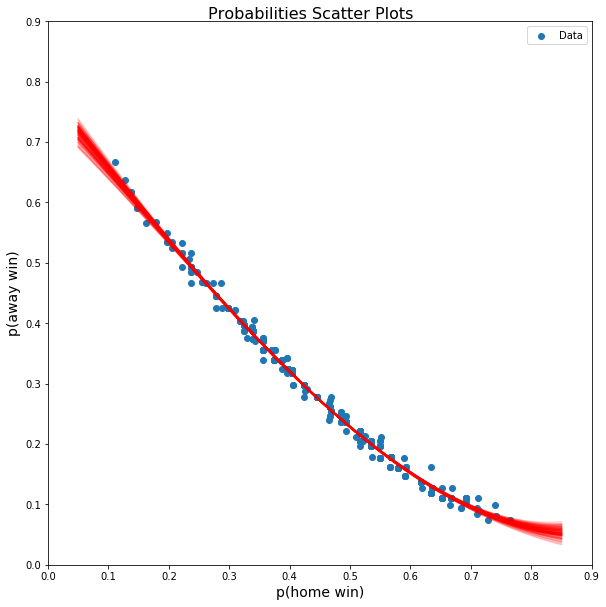

In [24]:
xmin = np.min(hwin)
xmax = np.max(hwin)
xrange = np.linspace(np.min(hwin)-0.1, np.max(hwin)+0.1, 100)
xrange = np.linspace(0.05, 0.85, 100)
#ymodel = model_func(xrange, *param_opt)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(hwin, awin, label = 'Data')
for param_opt in param_opts:
    ymodel = model_func(xrange, *param_opt)
    ax.plot(xrange, ymodel, color='red', alpha=0.2)
ax.set_xlabel('p(home win)', fontsize=14)
ax.set_ylabel('p(away win)', fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(0, 0.9)
ax.set_ylim(0, 0.9)

plt.suptitle('Probabilities Scatter Plots', fontsize=16, y=0.9)
plt.legend()
plt.show();

In [25]:
%matplotlib inline

## Mixture Density Network 

### to capture data variation as well as best fit

We will use this data to train a neural network with one hidden layer. This neural network is described by the following equation:

$y_{pred}(x) = w_{out} \tanh( w_{in} x + b_{in}) + b_{out}$

- $y_{pred}(x)$: this function $y_{pred}$ takes $x$ as input.
- $w_{in}, w_{out}$: weights for the input and output layers.
- $b_{in}, b_{out}$: biases for the input and output layers.
- $\tanh$: a nonlinear activation function.

Let's create this network using 20 hidden nodes.

In [26]:
n_input = 1
n_hidden = 20
n_output = 2

# create the network (also called a "model" of the data)
network = nn.Sequential(nn.Linear(n_input, n_hidden),
                        nn.Tanh(),
                        nn.Linear(n_hidden, n_output))

To train the network we must define a loss function. Also called a "cost function", this is a description of what counts as "better" or "worse" results, and allows us to modify the network to achieve the best results.

We will use the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) loss function.

In [27]:
loss_fn = nn.MSELoss()

We also need to pick an optimizer. Optimizers use the loss to determine which parameters in the network should be changed, and how much.

We will use the [RMSprop](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) optimizer, which happens to work well for this problem.

In [28]:
optimizer = torch.optim.RMSprop(network.parameters())

Now let's move our data from numpy to PyTorch. This requires:

1. Converting the data from `np.float64` (numpy default) to `np.float32` (Torch default).
2. Reshaping the data from `(n_samples)` to `(n_samples, n_input)`. Typically the first dimension is your batch size, but here we are processing all the samples in one batch.
3. Convert from a numpy array to a PyTorch tensor.
4. Initialize an input and output `Variable` that we can feed the x and y tensors.

We will use this naming convention:

- numpy arrays `x_data`
- PyTorch tensors `x_tensor`
- PyTorch Variables `x_variable`

In [29]:
# change data type and shape, move from numpy to torch
# note that we need to convert all data to np.float32 for pytorch
x_tensor = torch.from_numpy(np.float32(hwin).reshape(hwin.shape[0], n_input))
y_tensor = torch.from_numpy(np.float32(awin).reshape(awin.shape[0], n_input))
# z_tensor = torch.from_numpy(np.float32(z_data).reshape(n_samples, n_input))
x_variable = Variable(x_tensor)
y_variable = Variable(y_tensor, requires_grad=False)
# z_variable = Variable(z_tensor, requires_grad=False)

Now let's define a training loop. It will use the optimizer to minimize the loss function by modifying the network's parameters.

In [30]:
def train():
    for epoch in range(3000):
        y_pred = network(x_variable) # make a prediction
        loss = loss_fn(y_pred, y_variable) # compute the loss
        optimizer.zero_grad() # prepare the optimizer
        loss.backward() # compute the contribution of each parameter to the loss
        optimizer.step() # modify the parameters

        if epoch % 300 == 0:
            print(epoch, loss.item())

train()

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([380, 1])) that is different to the input size (torch.Size([380, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 0.34358590841293335
300 0.0014617537381127477
600 0.00107692857272923
900 0.0005564714083448052
1200 0.00044298722059465945
1500 0.0004227172757964581
1800 0.0001892799191409722
2100 0.00013538474740926176
2400 0.00011292592535028234
2700 0.00024525978369638324


Let's see how it performs by processing some evenly spaced samples.

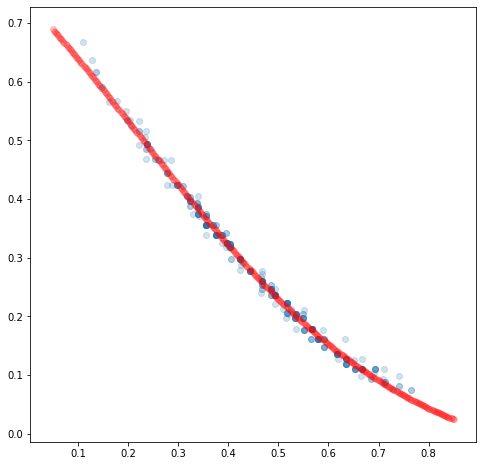

In [31]:
# evenly spaced samples from -10 to 10
x_test_data = np.linspace(0.05, 0.85, hwin.shape[0])

# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(hwin.shape[0], n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(hwin, awin, alpha=0.2)
# print(x_test_data)
# print(y_test_data)
plt.scatter(x_test_data, y_test_data[:,0], alpha=0.2, color='red')
plt.show()

The network can fit this sinusoidal data quite well, as expected. However, this type of fitting only when we want to approximate a one-to-one, or many-to-one relationship.

Suppose we invert the training data so we are predicting $x(y)$ instead of $y(x)$.

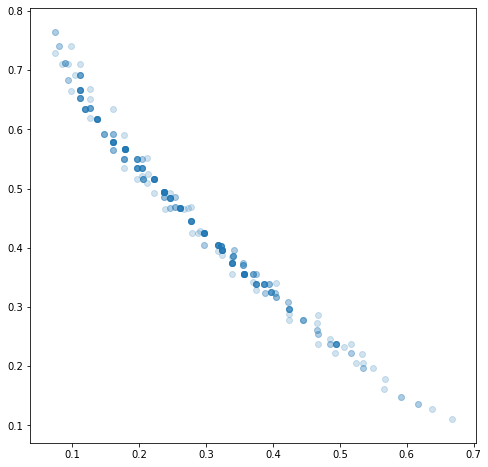

In [32]:
# plot x against y instead of y against x
plt.figure(figsize=(8, 8))
plt.scatter(awin, hwin, alpha=0.2)
plt.show()

If we use the same method to fit this data, it won't work well because the network can't output multiple values for each input. Because we used mean squared error loss, the network will try to output the average output value for each input.

In [33]:
x_variable.data = y_tensor
y_variable.data = x_tensor

train()

0 0.0004257594409864396
300 0.0002090241468977183
600 0.0003528363013174385
900 0.00019073714793194085
1200 0.00018516593263484538
1500 0.00018332716717850417
1800 0.0001862608769442886
2100 0.00019289662304800004
2400 0.040643833577632904
2700 0.00018059003923553973


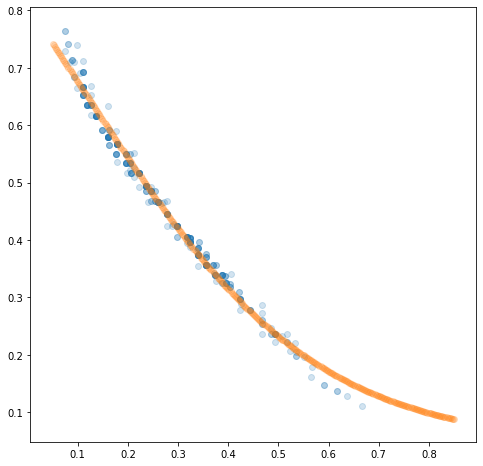

In [34]:
x_test_data = np.linspace(0.05, 0.85, hwin.shape[0])
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(hwin.shape[0], n_input))
x_test_variable.data = x_test_tensor

y_test_variable = network(x_test_variable)

# move from torch back to numpy
y_test_data = y_test_variable.data.numpy()

# plot the original data and the test data
plt.figure(figsize=(8, 8))
plt.scatter(awin, hwin, alpha=0.2)
plt.scatter(x_test_data, y_test_data[:,0], alpha=0.2)
plt.show()

Because our network only predicts one output value for each input, this approach will fail miserably.

What we want is a network that has the ability to predict a multiple output values for each input. In the next section we implement a Mixture Density Network (MDN) to achieve this task.

## Mixture Density Networks ##

Mixture Density Networks, developed by Christopher Bishop in the 1990s, are one way to produce multiple outputs from a single input. MDN predicts a *probability distribution* of possible output values. Then can sample several possible different output values for a given input.

This concept is quite powerful, and can be employed many current areas of machine learning research. It also allows us to calculate a sort of confidence factor in the predictions that the network is making.

The inverted sinusoid data we chose is not just a toy problem. In [the paper introducing MDNs](http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) an inverted sinusoid is used to describe the angle we need to move a robot arm to achieve a target location. MDNs are also used to model handwriting, where the next stroke is drawn from a probability distribution of multiple possibilities, rather than sticking to one prediction.

Bishop's implementation of MDNs will predict a class of probability distributions called Mixture of Gaussians or Gaussian Mixture Models, where the output value is modelled as a weighted sum of multiple Gaussians, each with different means and standard deviations.

So for each input $x$, we will predict a probability distribution function $P(y|x)$:

$P(y|x) = \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x))$

- $k$ is an index describing which Gaussian we are referencing. There are $K$ Gaussians total.
- $\sum_{k}^{K}$ is the summation operator. We sum every $k$ Gaussian across all $K$. You might also see $\sum_{k=0}^{K-1}$ or $\sum_{k=1}^{K}$ depending on whether an author is using zero-based numbering or not.
- $\Pi_k$ acts as a weight, or multiplier, for mixing every $k$ Gaussian. It is a function of the input $x$: $\Pi_k(x)$
- $\phi$ is the Gaussian function and returns the at $y$ for a given mean and standard deviation.
- $\mu_k$ and $\sigma_k$ are the parameters for the $k$ Gaussian: mean $\mu_k$ and standard deviation $\sigma_k$. Instead of being fixed for each Gaussian, they are also functions of the input $x$: $\mu_k(x)$ and $\sigma_k(x)$

All of $\sigma_{k}$ are positive, and all of the weights $\Pi$ sum to one:

$\sum_{k}^{K} \Pi_{k} = 1$

First our network must learn the functions $\Pi_{k}(x), \mu_{k}(x), \sigma_{k}(x)$ for every $k$ Gaussian. Then these functions can be used to generate individual parameters $\mu_k, \sigma_k, \Pi_k$ for a given input $x$. These parameters will be used to generate our pdf $P(y|x)$. Finally, to make a prediction, we will need to sample (pick a value) from this pdf.

In our implementation, we will use a neural network of one hidden layer with 20 nodes. This will feed into another layer that generates the parameters for 5 mixtures: with 3 parameters $\Pi_k$, $\mu_k$, $\sigma_k$ for each Gaussian $k$.

Our definition will be split into three parts.

First we will compute 20 hidden values $z_h$ from our input $x$.

$z_h(x) = \tanh( W_{in} x + b_{in})$

Second, we will use these hidden values $z_h$ to compute our three sets of parameters $\Pi, \sigma, \mu$:

$
z_\Pi = W_{\Pi} z_h + b_{\Pi}\\
z_\sigma = W_{\sigma} z_h + b_{\sigma}\\
z_\mu = W_{\mu} z_h + b_{\mu}
$

Third, we will use the output of these layers to determine the parameters of the Gaussians.

$
\Pi = \frac{\exp(z_{\Pi})}{\sum_{k}^{K} \exp(z_{\Pi_k})}\\
\sigma = \exp(z_{\sigma})\\
\mu = z_{\mu}
$

- $\exp(x)$ is the exponential function also written as $e^x$

We use a [*softmax*](https://en.wikipedia.org/wiki/Softmax_function) operator to ensure that $\Pi$ sums to one across all $k$, and the exponential function ensures that each weight $\Pi_k$ is positive. We also use the exponential function to ensure that every $\sigma_k$ is positive.

Let's define our MDN network.

In [35]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

We cannot use the `MSELoss()` function for this task, because the output is an entire description of the probability distribution and not just a single value. A more suitable loss function is the logarithm of the likelihood of the output distribution vs the training data:

$loss(y | x) = -\log[ \sum_{k}^{K} \Pi_{k}(x) \phi(y, \mu_{k}(x), \sigma_{k}(x)) ]$

So for every $x$ input and $y$ output pair in the training data set, we can compute a loss based on the predicted distribution versus the actual distribution, and then attempt the minimise the sum of all the costs combined. To those who are familiar with logistic regression and cross entropy minimisation of softmax, this is a similar approach, but with non-discretised states.

We have to implement this cost function ourselves:

In [36]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

Let's create our MDN with 20 hidden nodes and 5 Gaussians.

In [37]:
network = MDN(n_hidden=20, n_gaussians=5)

We'll use a different optimizer this time called Adam that is more suited to this task.

In [38]:
optimizer = torch.optim.Adam(network.parameters())

We could generate more data to train the MDN, but what we have is nearly enough.

In [39]:
mdn_x_data = hwin
mdn_y_data = awin

mdn_x_tensor = y_tensor
mdn_y_tensor = x_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)

Finally, let's define a new training loop. We need a training loop that can handle the new loss function, and the MDN needs to train longer than the previous network.

In [40]:
def train_mdn():
    for epoch in range(3000):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(epoch, loss.item())

train_mdn()

0 0.9233636856079102
500 -3.064100980758667
1000 -3.1815943717956543
1500 -3.201611042022705
2000 -3.2162067890167236
2500 -3.2269952297210693


Once the training is finished, we can observe all the parameters for the Gaussians and see how they vary with respect to the input $x$.

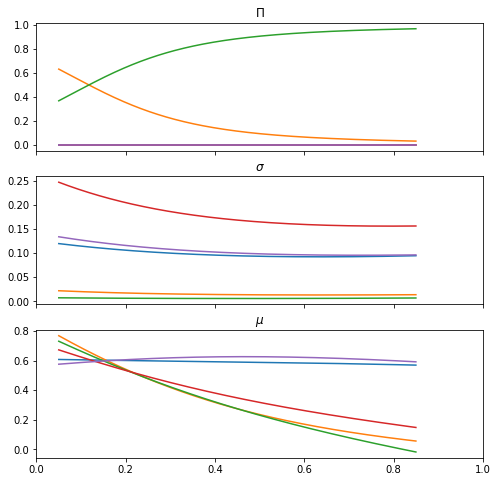

In [41]:
pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([0,1])
plt.show()

We can also plot the $\mu$ of each Gaussian with respect to $x$, and show the range of by highlighting a region between $\mu-\sigma$ and $\mu+\sigma$.

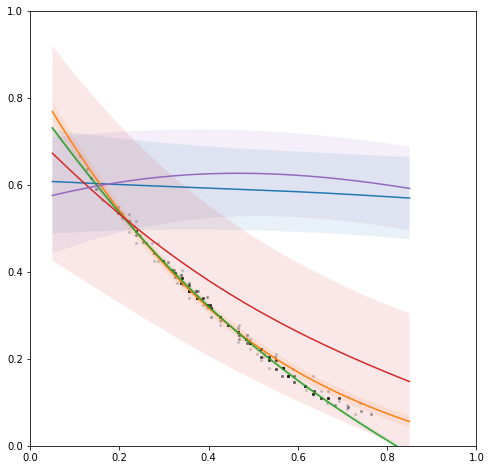

In [42]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In the plot above, we see that for every point on the $x$-axis, there are multiple lines or states where $y$ may be, and we select these states with probabilities modelled by $\Pi$. Note that the network won't find an ideal solution every time. It's possible to get lower loss by using more Gaussians, but the results are harder to interpret.

If we want to sample from the network we will need to pick a Gaussian $k$ and pick a value (sample) from that Gaussian. Here we use a trick called [Gumbel softmax sampling](http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/) to pick our $k$. We treat the $\Pi$ weights as a discrete distribution of probabilities, and sample one $k$ for each row of `pi_data`.

In [43]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)

Now that we have selected $k$ for each row, we can select $\sigma$ and $\mu$ as well. We will use `np.random.randn` to sample from each Gaussian, scaling it by $\sigma$ and offsetting it by $\mu$.

In [44]:
indices = (np.arange(hwin.shape[0]), k)
rn = np.random.randn(hwin.shape[0])
sampled = rn * sigma_data[indices] + mu_data[indices]

With these sampled $y$ values, we can overlay them on the original distribution to see how accurately the network captures the shape.

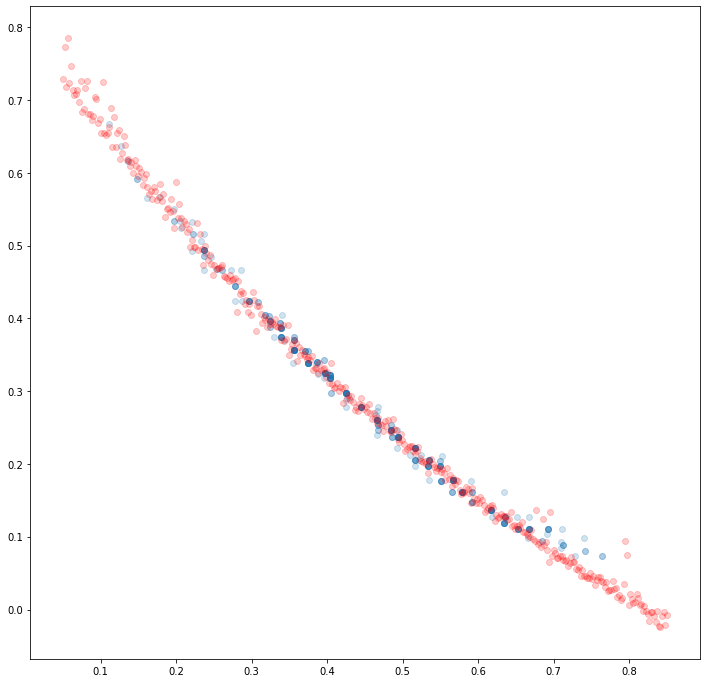

In [45]:
plt.figure(figsize=(12, 12))
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2)
plt.scatter(x_test_data, sampled, alpha=0.2, color='red')
plt.show()

Some other things to try:
    
- What other constraints might we enforce? Is it ever helpful to encourage $\Pi$ to be sparse to maintain a "simple" distribution?
- What kinds of regularization can we add to the network?
- Often very small sigma can create problems, it might be helpful to add `sigma += 0.01` inside the MDN.
- How do more or fewer Gaussians affect the result?
- How do more or fewer hidden nodes affect the result?
- What other kinds of nonlinear activation functions work besides `Tanh()`? Try `Sigmoid()` too.
- How do these plots move if you draw them in realtime while the network is training?
- What happens when if you use the [*softplus*](https://en.wikipedia.org/wiki/Softplus) function for making the $\sigma$ positive, instead of $\exp(x)$?

## References

In [ ]:
http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/
    
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.120.5685&rep=rep1&type=pdf
https://github.com/sagelywizard/pytorch-mdn